Using cuda device training.
Using 0 dataloader workers
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


validation...: 100%|██████████| 6352/6352 [04:35<00:00, 23.02it/s]
C:\Users\forever\anaconda3\envs\pytorch3.8-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sample 0 is in cluster 0
Sample 1 is in cluster 2
Sample 2 is in cluster 3
Sample 3 is in cluster 3
Sample 4 is in cluster 0
Sample 5 is in cluster 0
Sample 6 is in cluster 2
Sample 7 is in cluster 2
Sample 8 is in cluster 0
Sample 9 is in cluster 2
Sample 10 is in cluster 2
Sample 11 is in cluster 2
Sample 12 is in cluster 2
Sample 13 is in cluster 2
Sample 14 is in cluster 2
Sample 15 is in cluster 0
Sample 16 is in cluster 2
Sample 17 is in cluster 2
Sample 18 is in cluster 0
Sample 19 is in cluster 0
Sample 20 is in cluster 3
Sample 21 is in cluster 0
Sample 22 is in cluster 0
Sample 23 is in cluster 1
Sample 24 is in cluster 2
Sample 25 is in cluster 0
Sample 26 is in cluster 0
Sample 27 is in cluster 2
Sample 28 is in cluster 2
Sample 29 is in cluster 0
Sample 30 is in cluster 0
Sample 31 is in cluster 0
Sample 32 is in cluster 0
Sample 33 is in cluster 0
Sample 34 is in cluster 2
Sample 35 is in cluster 0
Sample 36 is in cluster 0
Sample 37 is in cluster 0
Sample 38 is in cluste

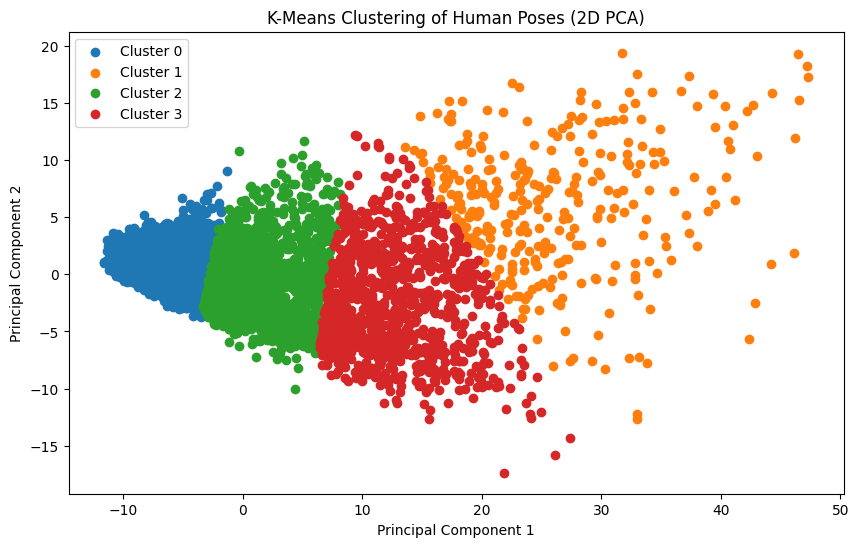

Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=1.17s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: keypoints
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.766
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.936
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.846
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.741
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.947
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.864
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.764
 Average Recall     (AR) @[ IoU=0.50:0.95

In [7]:
"""
该脚本用于调用训练好的模型权重去计算验证集/测试集的COCO指标
"""

import os
import json

import joblib
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from model import HighResolutionNet
from train_utils import EvalCOCOMetric
from my_dataset_coco import CocoKeypoint
import transforms

%matplotlib inline

def calculate_angle(p1, p2, p3):
    """Calculate the angle between the line p1-p2 and p2-p3."""
    vector_12 = np.array([p2[0] - p1[0], p2[1] - p1[1]])
    vector_23 = np.array([p3[0] - p2[0], p3[1] - p2[1]])
    norm_12 = np.linalg.norm(vector_12)
    norm_23 = np.linalg.norm(vector_23)

    if norm_12 == 0 or norm_23 == 0:
        return np.nan  # 返回NaN表示无法计算角度

    cosine_angle = np.dot(vector_12, vector_23) / (norm_12 * norm_23)
    # 防止浮点数计算误差导致的超出范围问题
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)


def extract_features(keypoints):
    features = []
    # 计算肩膀和臀部的中点
    left_shoulder = keypoints[5]
    right_shoulder = keypoints[6]
    left_hip = keypoints[11]
    right_hip = keypoints[12]
    midpoint_shoulder = [(left_shoulder[0] + right_shoulder[0]) / 2, (left_shoulder[1] + right_shoulder[1]) / 2]
    midpoint_hip = [(left_hip[0] + right_hip[0]) / 2, (left_hip[1] + right_hip[1]) / 2]

    # 计算头部和肩膀、肩膀和臀部之间的角度
    torso_angle = calculate_angle(keypoints[0], midpoint_shoulder, midpoint_hip)
    shoulder_hip_angle = calculate_angle(midpoint_shoulder, midpoint_hip,
                                         [(left_hip[0] + right_hip[0]) / 2, (left_hip[1] + right_hip[1]) / 2])

    # 添加相对高度特征
    height_features = keypoints[:, 1] - keypoints[0, 1]

    # 添加关键点之间的距离特征
    distance_features = []
    for i in range(len(keypoints)):
        for j in range(i + 1, len(keypoints)):
            distance_features.append(np.linalg.norm(keypoints[i] - keypoints[j]))

    features.extend([torso_angle, shoulder_hip_angle])
    features.extend(height_features)
    features.extend(distance_features)

    return features


def summarize(self, catId=None):
    """
    Compute and display summary metrics for evaluation results.
    Note this functin can *only* be applied on the default parameter setting
    """

    def _summarize(ap=1, iouThr=None, areaRng='all', maxDets=100):
        p = self.params
        iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}'
        titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
        typeStr = '(AP)' if ap == 1 else '(AR)'
        iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
            if iouThr is None else '{:0.2f}'.format(iouThr)

        aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
        mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]

        if ap == 1:
            # dimension of precision: [TxRxKxAxM]
            s = self.eval['precision']
            # IoU
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]

            if isinstance(catId, int):
                s = s[:, :, catId, aind, mind]
            else:
                s = s[:, :, :, aind, mind]

        else:
            # dimension of recall: [TxKxAxM]
            s = self.eval['recall']
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]

            if isinstance(catId, int):
                s = s[:, catId, aind, mind]
            else:
                s = s[:, :, aind, mind]

        if len(s[s > -1]) == 0:
            mean_s = -1
        else:
            mean_s = np.mean(s[s > -1])

        print_string = iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s)
        return mean_s, print_string

    stats, print_list = [0] * 10, [""] * 10
    stats[0], print_list[0] = _summarize(1, maxDets=20)
    stats[1], print_list[1] = _summarize(1, maxDets=20, iouThr=.5)
    stats[2], print_list[2] = _summarize(1, maxDets=20, iouThr=.75)
    stats[3], print_list[3] = _summarize(1, maxDets=20, areaRng='medium')
    stats[4], print_list[4] = _summarize(1, maxDets=20, areaRng='large')
    stats[5], print_list[5] = _summarize(0, maxDets=20)
    stats[6], print_list[6] = _summarize(0, maxDets=20, iouThr=.5)
    stats[7], print_list[7] = _summarize(0, maxDets=20, iouThr=.75)
    stats[8], print_list[8] = _summarize(0, maxDets=20, areaRng='medium')
    stats[9], print_list[9] = _summarize(0, maxDets=20, areaRng='large')

    print_info = "\n".join(print_list)

    if not self.eval:
        raise Exception('Please run accumulate() first')

    return stats, print_info


def save_info(coco_evaluator,
              save_name: str = "record_mAP.txt"):
    # calculate COCO info for all keypoints
    coco_stats, print_coco = summarize(coco_evaluator)

    # 将验证结果保存至txt文件中
    with open(save_name, "w") as f:
        record_lines = ["COCO results:", print_coco]
        f.write("\n".join(record_lines))


def main():
    #     # 使用设备类型
    # parser.add_argument('--device', default='cuda:0', help='device')
    # 
    # parser.add_argument('--resize-hw', type=list, default=[256, 192], help="resize for predict")
    # # 是否开启图像翻转
    # parser.add_argument('--flip', type=bool, default=True, help='whether using flipped images')
    # 
    # # 数据集的根目录
    # parser.add_argument('--data-path', default='./data/coco2017', help='dataset root')
    # 
    # # 训练好的权重文件
    # parser.add_argument('--weights-path', default='./pose_hrnet_w32_256x192.pth', type=str, help='training weights')
    # 
    # # batch size
    # parser.add_argument('--batch-size', default=1, type=int, metavar='N',
    #                     help='batch size when validation.')
    # # 类别索引和类别名称对应关系
    # parser.add_argument('--label-json-path', type=str, default="person_keypoints.json")
    # # 原项目提供的验证集person检测信息，如果要使用GT信息，直接将该参数置为None
    # parser.add_argument('--person-det', type=str, default="./COCO_val2017_detections_AP_H_56_person.json")
    # args = parser.parse_args()
    device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
    print("Using {} device training.".format(device.type))

    keypoints_list = []

    data_transform = {
        "val": transforms.Compose([
            transforms.AffineTransform(scale=(1.25, 1.25), fixed_size=[256, 192]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

    # read class_indict
    label_json_path = "person_keypoints.json"
    assert os.path.exists(label_json_path), "json file {} dose not exist.".format(label_json_path)
    with open(label_json_path, 'r') as f:
        person_coco_info = json.load(f)

    data_root = './data/coco2017'

    # 注意这里的collate_fn是自定义的，因为读取的数据包括image和targets，不能直接使用默认的方法合成batch
    batch_size = 1
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using %g dataloader workers' % nw)

    # load validation data set
    val_dataset = CocoKeypoint(data_root, "val", transforms=data_transform["val"], det_json_path=None)
    # VOCdevkit -> VOC2012 -> ImageSets -> Main -> val.txt
    # val_dataset = VOCInstances(data_root, year="2012", txt_name="val.txt", transforms=data_transform["val"])
    val_dataset_loader = torch.utils.data.DataLoader(val_dataset,
                                                     batch_size=batch_size,
                                                     shuffle=False,
                                                     pin_memory=True,
                                                     num_workers=nw,
                                                     collate_fn=val_dataset.collate_fn)

    # create model
    model = HighResolutionNet()

    # 载入你自己训练好的模型权重
    weights_path = './pose_hrnet_w32_256x192.pth'
    assert os.path.exists(weights_path), "not found {} file.".format(weights_path)
    model.load_state_dict(torch.load(weights_path, map_location='cpu'))
    # print(model)
    model.to(device)

    # evaluate on the val dataset
    key_metric = EvalCOCOMetric(val_dataset.coco, "keypoints", "key_results.json")
    model.eval()
    with torch.no_grad():
        for images, targets in tqdm(val_dataset_loader, desc="validation..."):
            # 将图片传入指定设备device
            images = images.to(device)

            # inference
            outputs = model(images)
            if True:
                flipped_images = transforms.flip_images(images)
                flipped_outputs = model(flipped_images)
                flipped_outputs = transforms.flip_back(flipped_outputs, person_coco_info["flip_pairs"])
                # feature is not aligned, shift flipped heatmap for higher accuracy
                # https://github.com/leoxiaobin/deep-high-resolution-net.pytorch/issues/22
                flipped_outputs[..., 1:] = flipped_outputs.clone()[..., 0:-1]
                outputs = (outputs + flipped_outputs) * 0.5

            # decode keypoint
            reverse_trans = [t["reverse_trans"] for t in targets]
            outputs = transforms.get_final_preds(outputs, reverse_trans, post_processing=True)

            keypoints_list.append(outputs[0][0])
            # print(f"keypoint: {len(keypoints_list)}")
            # print(f"keypoint: {outputs[0]},scores: {outputs[1]}")
            # print(f"keypoints_list: {len(keypoints_list[0][0])}")

            key_metric.update(targets, outputs)

    # 保存关键点信息

    # 提取所有样本的特征
    features_list = [extract_features(keypoints) for keypoints in keypoints_list]
    # 将NaN值替换为0或其他合适的值
    features_list = np.nan_to_num(features_list)
    # 标准化特征
    scaler = StandardScaler()
    features_list = scaler.fit_transform(features_list)
    # 使用PCA降维到两个主要特征
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features_list)
    # 使用K-Means进行聚类
    kmeans = KMeans(n_clusters=4, random_state=0).fit(features_2d)
    labels = kmeans.labels_
    # 打印每个样本的聚类标签
    for i, label in enumerate(labels):
        print(f"Sample {i} is in cluster {label}")

    # 保存模型
    joblib.dump(kmeans, './pkl/kmeans_model.pkl')
    joblib.dump(scaler, './pkl/scaler.pkl')
    joblib.dump(pca, './pkl/pca.pkl')

    # 可视化聚类结果
    plt.figure(figsize=(10, 6))
    for i in range(4):  # 假设有4个聚类
        cluster = np.array([features_2d[j] for j in range(len(features_2d)) if labels[j] == i])
        plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i}')
    plt.legend()
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('K-Means Clustering of Human Poses (2D PCA)')
    plt.show()

    key_metric.synchronize_results()
    key_metric.evaluate()

    save_info(key_metric.coco_evaluator, "keypoint_record_mAP.txt")


if __name__ == "__main__":
    main()
